# Automated Logo Generation Sample
## Overview
Designing a compelling and effective company/brand logo is crucial yet time-consuming and expensive. This usecase explores an AI-driven approach to streamlines logo generation by combining the capabitlities of small language models and diffusion models

## How it works?
<img width=800 alt="image" src="./assets/logo_generation.png"/>

## Prerequisites
Run the below cell if you have not installed any necessary packages. Restart the kernel if required.

In [ ]:
! pip install -r requirements.txt

## Import Necessary Packages

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from diffusers import DiffusionPipeline, StableDiffusion3Pipeline
import ipywidgets as widgets
from IPython.display import display

## Save logo into a local directory

In [2]:
def save_image(image, model, company_name):
    if model == "stabilityai/stable-diffusion-3-medium-diffusers":
        model_name = "sd3m"
    else:
        model_name = "sd3.5m"
    return image.save(f"./prompt_engg/{company_name} {model_name}.png")

## Diffusion Prompt Generation using SLM

With the help of few-shot prompt strategy, small language model(SLM) converts a structured company information into a detailed image diffusion prompt which further guides the diffusion model.

In [3]:
def generate_diffusion_prompt(prompt):
    tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")
    model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B")
    device = "xpu" if torch.xpu.is_available() else "cpu"
    model = model.to(device)    
    inputs = tokenizer(prompt, return_tensors="pt")
    inputs = inputs.to(device)
    torch.xpu.empty_cache()
    outputs = model.generate(
        **inputs,
        max_length=512,  
        temperature=0.7,
        do_sample=True,
        top_p=1.0,
    )
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    text = generated_text.find("Output Prompt:\n")
    diffusion_prompt = generated_text[text + len("Output Prompt:\n"):].strip()
    del model, tokenizer, inputs, outputs
    return diffusion_prompt

### Few-shot prompt to the Small Language Model(SLM)

In [12]:
def make_prompt(name, info, style, color, ctype):
    prompt = f"""
    You are a helpful assistant that can generate creative prompts for image diffusion models. 
    Your goal is to create a prompt that are specific and tailored to the given company information. 
    I will provide you with examples of company details and corresponding image diffusion prompts.

    Here are a few examples to get us started:
    
    Example 1:
    Company Name: TechForward Solutions
    Company Info: A software company specializing in AI solutions for businesses.
    Company Type: Technology: Software, hardware
    Logo Style: Modern, Geometric
    Logo Color Palette: Electric blue, silver, white
    Prompt: A modern, geometric logo for TechForward Solutions, featuring a stylized, interconnected network of glowing lines, in electric blue, silver, and white. Display 'TechForward Solutions'.

    Example 2:
    Company Name: Sweet Harmony Bakery
    Company Info: A local bakery offering a variety of pastries, cakes, and breads.
    Company Type: Food
    Logo Style: Vintage, Hand-drawn
    Logo Color Palette: Warm beige, pastel pink, light yellow
    Prompt: A vintage, hand-drawn logo for Sweet Harmony Bakery, featuring a delicate illustration of a pastry, cake, and bread, in warm beige, pastel pink, and light yellow. Display 'Sweet Harmony Bakery'
    
    Example 3:
    Company Name: OceanVista Resorts
    Company Info: A luxury resort chain with locations in tropical coastal areas.
    Company Type: Travel
    Logo Style: Elegant, Minimalist
    Logo Color Palette: Turquoise, sand, white
    Prompt: An elegant, minimalist logo for OceanVista Resorts, featuring a stylized depiction of a wave and a setting sun, in turquoise, sand, and white. Display 'OceanVista Resorts'.
    
    Now, here's the company information for the logo we need:

    Company Name: {name}
    Company Info: {info}
    Company Type: {ctype}
    Logo Style: {style}
    Logo Color Palette: {color}
    Output Prompt:
    """
    return prompt

## User Input: Company/Brand Information

In [13]:
company_name_text = widgets.Text(
    value='',
    placeholder='Enter company name',
    description='Company Name:',
    disabled=False
)

company_info_text = widgets.Text(
    value='',
    placeholder='Enter company information',
    description='Company Info:',
    disabled=False
)

company_type_dropdown = widgets.Dropdown(
    options=[
        'E-commerce: Online store',
        'Food Business: Restaurant, cafe',
        'Technology: Software, hardware',
        'Retail: Shops, stores',
        'Service: Consulting, agency',
        'Other: other business'
    ],
    value='E-commerce: Online store',
    description='Company Type:',
    disabled=False,
)

style_dropdown = widgets.Dropdown(
    options=[
        'Modern: Clean, contemporary',
        'Minimalist: Simple, uncluttered',
        'Illustrative: Detailed, artistic',
        'Organic: Natural, flowing',
        'Geometric: Shapes, patterns',
        'Vintage: Retro, classic'
    ],
    value='Modern: Clean, contemporary',
    description='Style:',
    disabled=False,
)

color_palette_dropdown = widgets.Dropdown(
    options=[
        'Cool: Pastel Blues, greens, purples',
        'Warm: Reds, oranges, yellows',
        'Neutral: Grays, browns, beiges',
        'Vibrant: Bright, colorful',
        'Monochrome: Single color',
        'Earthy: Natural tones'
    ],
    value='Cool: Pastel Blues, greens, purples',
    description='Color Palette:',
    disabled=False,
)


output_area = widgets.Output()

def on_button_click(b):
    """Handles the button click event, generating and displaying the prompt."""
    global final_prompt
    with output_area:
        output_area.clear_output()  
        name = company_name_text.value
        info = company_info_text.value
        ctype = company_type_dropdown.value
        style = style_dropdown.value
        color = color_palette_dropdown.value
        # identity = brand_identity_text.value

        prompt = make_prompt(name, style, color, ctype, info)
        final_prompt = generate_diffusion_prompt(prompt)
        print(f"\nGenerated Prompt: {final_prompt}")

generate_button = widgets.Button(
    description='Generate Prompt',
    button_style='primary',
    tooltip='Click to generate the logo design prompt',
    disabled=False
)
prompt = generate_button.on_click(on_button_click)  

input_widgets = widgets.VBox([
    company_name_text,
    company_info_text,
    company_type_dropdown,
    style_dropdown,
    color_palette_dropdown,
    generate_button,
    output_area 
])

display(input_widgets)


In [16]:
options = [
        "stabilityai/stable-diffusion-3-medium-diffusers",
        "stabilityai/stable-diffusion-3.5-medium",
        # "stabilityai/stable-diffusion-3.5-large",
]
model = widgets.Dropdown(
    options=options,
    value='stabilityai/stable-diffusion-3-medium-diffusers',
    description='Diffusion Model:',
    disabled=False,
)

In [15]:
display(model)

Dropdown(description='Diffusion Model:', options=('stabilityai/stable-diffusion-3-medium-diffusers', 'stabilit…

## Logo Generation using Diffusion Models

In [17]:
def logo_generator(model):
    pipe = StableDiffusion3Pipeline.from_pretrained(
        model,
        text_encoder_3=None,
        tokenizer_3=None,
        torch_dtype=torch.bfloat16)
    pipe = pipe.to("xpu")
    torch.xpu.empty_cache()
    image = pipe(
        prompt=final_prompt,
        negative_prompt="blurry, incorrect spelling, wrong names",
        num_inference_steps=30,
        height=512,
        width=512,
        guidance_scale=8.5,
    ).images[0]
    del pipe
    return image

In [20]:
image = logo_generator(model.value)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

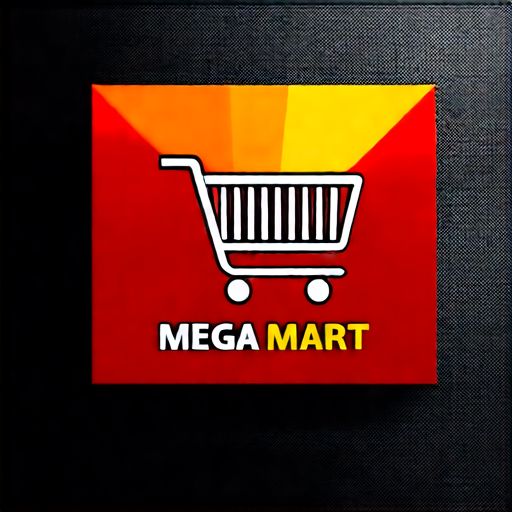

In [21]:
image

In [ ]:
save_image(image, model.value, company_name_text.value)